# Intro
This notebook is intended to reduplicate the example of applying the Coordinate Ascent Varaitional Inference (CAVI) method on Gaussian Mixture Model (GMM), which is desribed in David M. Blei's 'Variational Inference: A Review for Statisticians'. You're encouraged to go through the paper and do the derivation of the mathematics on your own. Hope the notebook be a help of you.



## Variational Inference
Let $\mathbf{x} = x_{1:n}$ be a set of observed variables and $\mathbf{z} = z_{1:m}$ be a set of latent variables, with joint density $p(\mathbf{z}, \mathbf{x})$. The inference problem is to compute the conditional density of the latent variables given the observations, $p(\mathbf{z}|\mathbf{x})$. Variational inference is a widely-used method to approximate the conditional density of latent variables given observed variables. The key idea is to solve this problem with optimization, i.e., find the best candidate approximation $q(\mathbf{z})$ within the given variational family $\mathcal{L}$ that maximizing the evidence lower bound $ELBO(q)$.

Variational inference is a general framework of approximating the conditional density rather one specific method, where a set of core compoments need to be instantialized to solve the optimization problem. These compoments are:
- the closed form of joint density over latent variables and data, $p(\mathbf{z}, \mathbf{x})$;
- the variational family $\mathcal{L}$ that defines the form of $q(\mathbf{z})$;
- the specific algorithm used for the optimizating ELBO.

This notebook is meant for the reproduction of the example of applying CAVI method on GMM, and is organized as follows to elaborate the above-methioned three compoments:
- show the data generation process of GMM - $p(\mathbf{z}, \mathbf{x})$;
- brief the mean-field variational family which defines the form of $q(\mathbf{z})$;
- show the form of elbo under the mean-field + GMM setting;
- implement the CAVI method on solving the elbo-optimzaiton problem;
- present the performace of cavi-gmm.


## Preliminaries
You shall have a basic comprehension on the following concepts:
- the goal of varaitional inference
- KL divergence and ELBO
- the mean-field variational family
- coordinate ascent method

In [1]:
from zoo.core.configs import Config
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# set up the experiment configuration
config = Config(num_cluster=4, num_data=10000, prior_var=16, max_step=25)

# Gaussian Mixture Model
At very first, we define GMM's generative process of data as described in Section 2.1. 


There are $K$ mixture components, corresponding to $K$ Gaussian distributions with means $\mathbf{\mu} = \{\mu_1, \mu_2, ... \mu_K\}$. The mean parameters are drawn independently from a common prior $p(\mu_k)$, which assumed to be a Gaussian $\mathcal{N}(0, \sigma^2)$; the prior variance is a hyperparameter. 

To generate an observation $x_i$, a cluster assignment $c_i$ is first chosen. Then $xi$ is drawn from the corresponding Gaussian $\mathcal{N}(c_i^T\mathbf{u}, 1)$. $c_i$ is $K$-dimensional one-hot vector, indicating which latent cluster $x_i$ comes from and is drawn from a categorical distribution over $\{1...K\}$. 

<center>
<img src="imgs/cavi_gmm/generative_process.jpg" width="60%">
</center>

In [3]:
def get_data(K: int, N: int, var: float):
    """
    generate data according to the generative process defined in equations (4), (5), (6)
    
    :param K: number of clusters
    :param N: number of data points
    :param var: global hyper-parameter, the variance of the prior Gaussian distribution of \mu_k,
            i.e. the square term in `\mu_k ~ N(0, \sigma^2)`

    :return:
        x - dataset [N, ]
        cluster_center - global latent variable [K, ]
        cluster_assignment - local latent variable, cluster-index [N, ]
    """
    cluster_center = np.random.randn(K) * np.sqrt(var)
    cluster_assignment = np.random.randint(0, K, N)
    x = np.random.randn(N) + cluster_center[cluster_assignment]

    return x, cluster_center, cluster_assignment

# Mean-Field Variational Family

The mean-field variational family is used here to formalized the posterior density approximator:
$$
q(\mathbf{\mu}, \mathbf{c}) = \prod_k q(\mu_k;m_k, s^2_k) \prod_i q(c_i;\phi_i).
$$

The factor $q(\mu_k;m_k, s^2_k)$ is a Gaussian distribution on the $k$-th mixture component’s mean parameter; its mean is $m_k$ and its variance is $s^2_k$. The factor $q(c_i ;\phi)$ is a distribution on the $x_i$’s mixture assignment; its assignment probabilities are a $K$-dimenstional vector $\phi_i$.

Here we have asserted parametric forms for these factors: 
- the mixture components are Gaussian with variational parameters (mean and variance) specific to the $k$-th cluster; 
- the cluster assignments are categorical with variational parameters (cluster probabilities) specific to the $i$-th data point. 

A class `Approximator` here is used to cover:
- the defination of variational parameters
- the CAVI iteration logic (will be explained later)  
- the computaion of elbo-value

In [4]:
class Approximator(object):
    def __init__(self, K, N, var):
        # variational parameters: m - [K,], s2 - [K,], phi - [N, K]
        # var - global hyper parameter
        self.m, self.s2 = np.random.randn(K), np.random.random(K)
        self.phi = np.random.random(size=(N, K))
        self.phi /= np.sum(self.phi, axis=1, keepdims=True)
        self.var = var

    def coord_ascent_update(self, x):
        # apply CAVI update on the variational parameters
        # equation 34
        self.s2 = 1 / (np.sum(self.phi, axis=0) + 1 / self.var)
        self.m = np.sum(self.phi * np.expand_dims(x, 1), axis=0) / (np.sum(self.phi, axis=0) + 1 / self.var)

        # equation 26
        self.phi = np.exp(np.outer(x, self.m) - 1 / 2 * np.expand_dims(self.m ** 2 + self.s2, 0))
        # normalize phi
        self.phi /= np.sum(self.phi, axis=1, keepdims=True)

    def elbo(self, x):
        return compute_elbo(self.m,
                            self.s2,
                            self.phi,
                            self.var,
                            x
                            )

# ELBO 

Next, we implement the computation of ELBO under the mean-field + GMM setting, as described at Section 3.
<center>
<img src="imgs/cavi_gmm/elbo.jpg" width="60%">
</center>

In [5]:
def compute_elbo(m: np.ndarray, s2: np.ndarray, phi: np.ndarray, var: float, x: np.ndarray) -> float:
    """
    compute ELBO value according to equation (21) in the paper
    :param m: [K,]
    :param s2: [K,]
    :param phi: [N, K]
    :param var: variance of the prior prob of mu_k, shape: [2，], [var_x, var_y]
    :param x:  [N,]
    :return:
    """
    K, N = len(m), len(x)
    ret = 0.
    # \sum_k E[log p(\mu_k); m_k, s_k^2]
    ret += - 1 / 2 * np.sum(np.log(2 * np.pi * var) + (s2 + m ** 2) / var)
    
    # \sum_i E[log p(c_i); phi] --- is a const, can be removed
    ret += - np.log(K) * N
    
    # \sum_i E[log p(x_i|c_i, \mu_i); \phi_i, m, s^2]
    ret += - 1 / 2 * np.sum(
        phi * (np.log(2 * np.pi) +
               np.expand_dims(x ** 2, 1) - 2 * np.expand_dims(x, 1) * np.expand_dims(m, 0) +
               np.expand_dims(m ** 2 + s2, 0)))
    
    # - \sum_i E[log q(c_i; phi)]
    # we set log 0 as 0 to avoid generating Nan
    ret -= np.sum(phi * np.where(phi > 0, np.log(phi), 0))
    
    # - \sum_k E[log q(\mu_k; m_k, s_k^2)]
    ret -= - 1 / 2 * np.sum(np.log(2 * np.pi * s2) + 1)
    return ret

# CAVI algorithm
Using the ELBO and the mean-field family, we have cast approximate conditional inference as an optimization problem. 
Now we use coordinate ascent variational inference (CAVI) to solve it. CAVI iteratively optimizes each factor of the mean-field variational density, while holding the others fixed. It climbs the ELBO to a local optimum.
<center>
<img src="imgs/cavi_gmm/cavi_gmm.jpg" width="70%">
</center>

The parameter update steps within the while loop are defiend in `Approximator.coord_ascent_update` method.

In [6]:
def exp(config, x):
    """
    run CAVI on GMM model on the given one-dimensional dataset x
    :param config: experiment configuration
    :param x: dataset
    """
    model = Approximator(config.num_cluster, config.num_data, config.prior_var)
    exp_result = defaultdict(list)
    
    for _ in range(config.max_step):
        # apply update
        model.coord_ascent_update(x)
        
        # record model params and elbo value
        exp_result['m'].append(model.m)
        exp_result['elbo'].append(model.elbo(x))

    return exp_result

# Experiment
## The convergence of CAVI
We repeated running CAVI algorithm with the same dataset but different initializations of variational factors, and plotted the elbo-value curves of each signle run. Algorithm converges after 5-6 iterations.

Text(0.5, 0, 'iter')

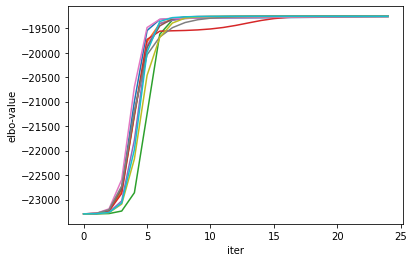

In [7]:
# generate data
x, cluster_center, cluster_assignment = get_data(config.num_cluster, config.num_data, config.prior_var)

# repeat experiment on different parameter initialization 10 times
exp_results = [exp(config, x) for _ in range(10)]

# plot result
for result in exp_results:
    plt.plot(result['elbo'])

plt.ylabel('elbo-value')
plt.xlabel('iter')

# The effectiveness of CAVI on GMM

We showed how the estimated cluster centers changed during the itertaive process. The black dashed line denotes the estimated cluster centers of GMM by CAVI.

We can see that:
- at first a few iterations, the estimated cluster centers are just random guess, and cannot be distinguished easily.
- after convergence, the centers of each cluster is located precisely.

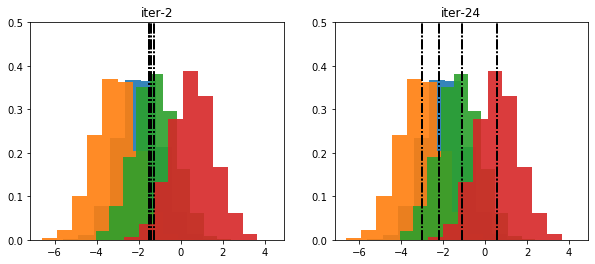

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

for k in range(config.num_cluster):
    points = x[cluster_assignment == k]
    *_, patch = ax[0].hist(points, alpha=0.9, density=True)
    ax[0].set_ylim(0, 0.5)
    
    ax[0].vlines(exp_results[0]['m'][2], 0, 1, color='k', linestyles='-.')
    ax[0].set_title('iter-2')

    
for k in range(config.num_cluster):
    points = x[cluster_assignment == k]
    *_, patch = ax[1].hist(points, alpha=0.9, density=True)
    ax[1].set_ylim(0, 0.5)
    
    ax[1].vlines(exp_results[0]['m'][config.max_step - 1], 0, 1, color='k', linestyles='-.')
    ax[1].set_title(f'iter-{config.max_step - 1}')